# Modeling Spotify Churn: A Statistical Analysis of Usage, Demographics, and Engagement
### Statistical Modelling & Simulation: Machine Project Phase 2
#### *S13 Group 6: Galicia, Mojica, Plurad, Ramirez, Tolentino*


## 1.1 Modelling the Relationship Between Skip Rate and Churn

#### Research Question: What is the relationship between a user’s skip_rate and the likelihood of customer churn (is_churned)?


## 1.2 Library Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from kmeans import KMeans
from rule_miner import RuleMiner
from mlxtend.preprocessing import TransactionEncoder

%load_ext autoreload
%autoreload 2

df = pd.read_csv("spotify_churn_dataset.csv")

print("Shape:", df.shape)
display(df.head())

print("\nColumn info:")
print(df.dtypes)

Bad value in file WindowsPath('C:/Users/Lance/.matplotlib/stylelib/seaborn-darkgrid.mplstyle'), line 3 ('axes.facecolor: #EAEAF2'): Key axes.facecolor: '' does not look like a color arg


Shape: (8000, 12)


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1



Column info:
user_id                    int64
gender                    object
age                        int64
country                   object
subscription_type         object
listening_time             int64
songs_played_per_day       int64
skip_rate                float64
device_type               object
ads_listened_per_week      int64
offline_listening          int64
is_churned                 int64
dtype: object


## 1.3 Data Preprocessing for Modelling


In [4]:
# is_churned column changed to boolean
if df["is_churned"].dtype == "object":
    df["is_churned"] = (
        df["is_churned"]
        .astype(str)
        .str.strip()
        .str.lower()
        .isin(["yes", "true", "1", "churned"])
    )
else:
    # if already 0/1 or bool, convert to bool
    df["is_churned"] = df["is_churned"].astype(bool)
    
# drops null values
df = df.dropna(subset=["skip_rate", "listening_time", "songs_played_per_day", "ads_listened_per_week"])

## 1.4 Clustering: Grouping Users by Listening Behaviour

Prepare the dataset for clustering analysis by selecting relevant features that may influence user behavior and churn.

In [5]:
# select columns for clustering
cluster_df = df[[
    "listening_time",
    "songs_played_per_day",
    "skip_rate",
    "ads_listened_per_week"
]].copy()

cluster_df.head()
cluster_df.shape

(8000, 4)

Performs K-Means clustering on cluster_df with k=3 clusters.

In [6]:
# Kmeans
k = 3
start_var = 0       
end_var = 4         
n_obs = cluster_df.shape[0]

kmeans_spotify = KMeans(k, start_var, end_var, n_obs, cluster_df)

centroids = kmeans_spotify.initialize_centroids(cluster_df)
centroids.round(2)

print("Initial centroids:")
print(centroids.round(2))

Initial centroids:
   listening_time  songs_played_per_day  skip_rate  ads_listened_per_week
0           248.0                  92.0       0.18                   35.0
1            10.0                   1.0       0.56                    0.0
2           108.0                  89.0       0.09                   49.0


c:\Users\Lance\OneDrive\Documents\GitHub\MODEL-PHASE-2\Phase 2\Phase 2\kmeans.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.centroids = pd.concat([self.centroids, point], ignore_index=True)


Trains the K-Means model on cluster_df for up to 300 iterations.

In [7]:
max_iters = 300  

spotify_clusters = kmeans_spotify.train(cluster_df, max_iters)

print("Cluster counts:")
for c in range(k):
    print(f"Cluster {c}: {(spotify_clusters == c).sum()} users")

df["cluster"] = spotify_clusters.values 
df.head()


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Done clustering!
Cluster counts:
Cluster 0: 2723 users
Cluster 1: 2642 users
Cluster 2: 2635 users


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned,cluster
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,True,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,False,2
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,True,2
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,False,1
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,True,0


Display scatter plot of Spotify users showing skip_rate vs listening_time, color-coded by cluster. 
Cluster centroids are overlaid as black stars (*) to visualize the cluster centers.

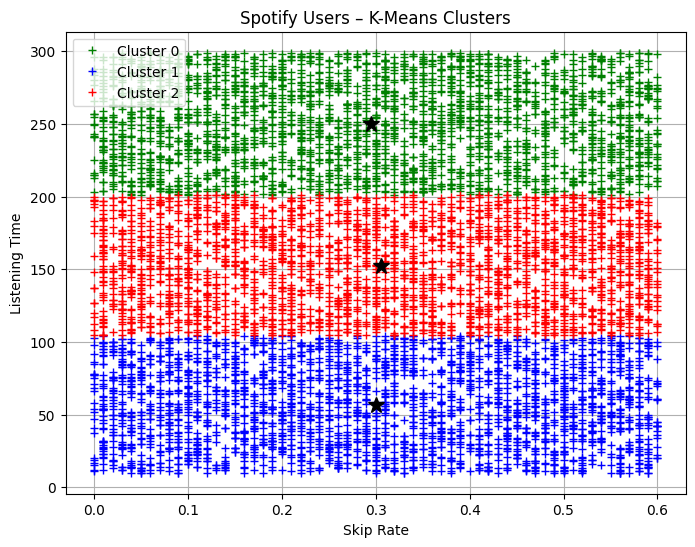

In [15]:
#scatter plot
plt.figure(figsize=(8, 6))

colors = ['g+', 'b+', 'r+']  

for c in range(k):
    subset = df.loc[df["cluster"] == c]
    plt.plot(
        subset["skip_rate"],
        subset["listening_time"],
        colors[c],
        label=f"Cluster {c}"
    )

# plot centroids 
for i in range(len(kmeans_spotify.centroids)):
    cx = kmeans_spotify.centroids.iloc[i]["skip_rate"]
    cy = kmeans_spotify.centroids.iloc[i]["listening_time"]
    plt.plot(cx, cy, 'k*', ms=12)

plt.xlabel("Skip Rate")
plt.ylabel("Listening Time")
plt.title("Spotify Users – K-Means Clusters")
plt.legend()
plt.grid()
plt.show()

Calculates and visualizes the churn rate for each cluster.

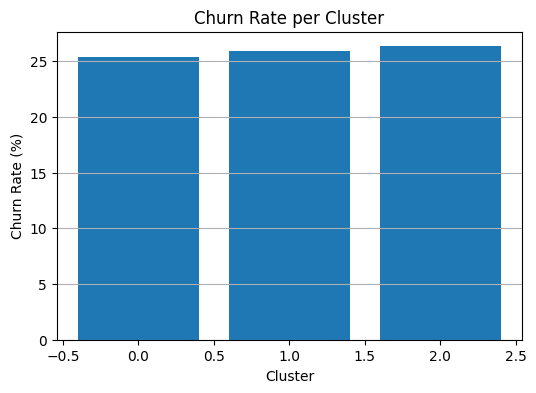

In [9]:
# churn rate per cluster
cluster_churn = df.groupby("cluster")["is_churned"].mean().reset_index()
cluster_churn["churn_rate_%"] = cluster_churn["is_churned"] * 100
cluster_churn

plt.figure(figsize=(6, 4))
plt.bar(cluster_churn["cluster"], cluster_churn["churn_rate_%"])
plt.xlabel("Cluster")
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate per Cluster")
plt.grid(axis="y")
plt.show()


## 1.5 Association Rule Mining: Understanding how skip rate relates to churn within each cluster

Prepares the data for association rule mining (ARM) within each cluster

In [10]:
cluster_rules = {}  # store rules per cluster

for c in df['cluster'].unique():
    cluster_df_arm = df[df['cluster'] == c].copy()
    
    # Binning skip_rate within this cluster
    cluster_df_arm['skip_rate_bin_fixed'] = pd.cut(
        cluster_df_arm['skip_rate'],
        bins=[0, 0.2, 1.0],
        labels=["low_skip", "higher_skip"]
    )
    
    # Convert churn boolean to label
    cluster_df_arm['churn_label'] = cluster_df_arm['is_churned'].map({True: "churn_yes", False: "churn_no"})
    
    # Drop any rows with missing bin
    cluster_df_arm = cluster_df_arm.dropna(subset=['skip_rate_bin_fixed', 'churn_label'])
    
    # Prepare transactions, convert everything to string
    transactions = cluster_df_arm.apply(
        lambda row: [str(row['skip_rate_bin_fixed']), str(row['churn_label'])],
        axis=1
    ).tolist()
    
    # One-hot encode
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    arm_ohe = pd.DataFrame(te_ary, columns=te.columns_)
    
    # Store for next step
    cluster_rules[c] = arm_ohe

Displays a summary of each cluster

In [11]:
print("Cluster summaries:\n")
for c in sorted(df['cluster'].unique()):
    cluster_size = len(df[df['cluster'] == c])
    avg_skip = df[df['cluster'] == c]['skip_rate'].mean()
    churn_rate = df[df['cluster'] == c]['is_churned'].mean() * 100

    print(f"Cluster {c}:")
    print(f"  Number of users: {cluster_size}")
    print(f"  Average skip rate: {avg_skip:.2f}")
    print(f"  Churn rate: {churn_rate:.2f}%\n")


Cluster summaries:

Cluster 0:
  Number of users: 2723
  Average skip rate: 0.29
  Churn rate: 25.38%

Cluster 1:
  Number of users: 2642
  Average skip rate: 0.30
  Churn rate: 25.97%

Cluster 2:
  Number of users: 2635
  Average skip rate: 0.31
  Churn rate: 26.34%



Generates all association rules from the one-hot encoded dataset (arm_ohe_fixed) using the RuleMiner class with a minimum support and confidence threshold

In [12]:
# Generate and display all unique association rules
# Initialize RuleMiner
support_threshold = max(1, int(0.005 * len(arm_ohe_fixed)))  # 0.5% of dataset
confidence_threshold = 0.1
rule_miner = RuleMiner(support_t=support_threshold, confidence_t=confidence_threshold)

# Generate all association rules
all_rules = rule_miner.get_association_rules(arm_ohe_fixed)

# Remove duplicates
seen = set()
unique_rules = []
for rule in all_rules:
    hashable_rule = (tuple(rule[0]), tuple(rule[1]))
    if hashable_rule not in seen:
        seen.add(hashable_rule)
        unique_rules.append(rule)

# Display all unique rules
print(f"Total unique rules: {len(unique_rules)}")
display(unique_rules)

NameError: name 'arm_ohe_fixed' is not defined

Filters the association rules generated to focus only on patterns where skip rate bins (low_skip or higher_skip) are the antecedents and churn labels (churn_yes or churn_no) are the consequents.

In [ ]:
# Define skip rate bins
skip_bins = ["low_skip", "higher_skip"]

# Filter rules where skip_rate is antecedent and churn_label is consequent
skip_to_churn_rules = [
    rule for rule in unique_rules
    if any(item in skip_bins for item in rule[0])  # antecedent contains skip_rate bin
    and any("churn" in item for item in rule[1])   # consequent contains churn label
]

# Display filtered rules
print("Filtered skip_rate → churn rules (no duplicates):")
display(skip_to_churn_rules)

print("Total filtered rules:", len(skip_to_churn_rules))

Filtered skip_rate → churn rules (no duplicates):


[[['higher_skip'], ['churn_no']],
 [['low_skip'], ['churn_no']],
 [['higher_skip'], ['churn_yes']],
 [['low_skip'], ['churn_yes']]]

Total filtered rules: 4


Generates cluster-specific skip rate → churn association rules

In [ ]:
cluster_association_rules = {}
confidence_threshold = 0.1  # 10% confidence

for c, arm_ohe in cluster_rules.items():
    # Initialize RuleMiner with support=1 (catch all)
    rule_miner = RuleMiner(support_t=1, confidence_t=confidence_threshold)
    rules = rule_miner.get_association_rules(arm_ohe)

    # Detect skip bins and churn labels in the one-hot columns
    skip_bins = [col for col in arm_ohe.columns if "skip" in col]
    churn_cols = [col for col in arm_ohe.columns if "churn" in col]

    # Filter rules: skip_rate → churn
    skip_to_churn = [
        rule for rule in rules
        if any(item in skip_bins for item in rule[0])
        and any(item in churn_cols for item in rule[1])
    ]

    # Remove duplicates 
    unique_rules = []
    seen = set()
    for rule in skip_to_churn:
        hashable_rule = (tuple(rule[0]), tuple(rule[1]))
        if hashable_rule not in seen:
            seen.add(hashable_rule)
            unique_rules.append(rule)

    cluster_association_rules[c] = unique_rules

for c in sorted(cluster_association_rules.keys()):
    rules = cluster_association_rules[c]
    print(f"\nCluster {c} rules (skip_rate → churn):")
    if rules:
        display(rules)
    else:
        print("No rules found.")


Cluster 0 rules (skip_rate → churn):


[[['higher_skip'], ['churn_no']],
 [['low_skip'], ['churn_no']],
 [['higher_skip'], ['churn_yes']],
 [['low_skip'], ['churn_yes']]]


Cluster 1 rules (skip_rate → churn):


[[['higher_skip'], ['churn_no']],
 [['low_skip'], ['churn_no']],
 [['higher_skip'], ['churn_yes']],
 [['low_skip'], ['churn_yes']]]


Cluster 2 rules (skip_rate → churn):


[[['higher_skip'], ['churn_no']],
 [['low_skip'], ['churn_no']],
 [['higher_skip'], ['churn_yes']],
 [['low_skip'], ['churn_yes']]]

Computes basic metrics for each cluster’s skip rate → churn rules

In [ ]:
cluster_rule_metrics = {}

for c, rules in cluster_association_rules.items():
    if rules:
        metrics = []
        for rule in rules:
            X, Y = rule[0], rule[1]
            support_XY = cluster_rules[c].loc[:, X + Y].all(axis=1).sum() / len(cluster_rules[c])
            support_X = cluster_rules[c].loc[:, X].all(axis=1).sum() / len(cluster_rules[c])
            confidence = support_XY / support_X if support_X > 0 else 0
            metrics.append({
                'antecedent': X,
                'consequent': Y,
                'support': support_XY,
                'confidence': confidence
            })
        cluster_rule_metrics[c] = pd.DataFrame(metrics)

Stores all metrics in a list of dictionaries per cluster

In [ ]:
cluster_rule_metrics = {}  # store metrics per cluster

for c, rules in cluster_association_rules.items():
    metrics_list = []

    if rules:
        for rule in rules:
            X, Y = rule[0], rule[1]

            # Support(X ∪ Y)
            support_XY = cluster_rules[c].loc[:, X + Y].all(axis=1).sum() / len(cluster_rules[c])

            # Support(X) and Support(Y)
            support_X = cluster_rules[c].loc[:, X].all(axis=1).sum() / len(cluster_rules[c])
            support_Y = cluster_rules[c].loc[:, Y].all(axis=1).sum() / len(cluster_rules[c])

            # Confidence
            confidence = support_XY / support_X if support_X > 0 else 0

            # Lift
            lift = confidence / support_Y if support_Y > 0 else 0

            # Leverage
            leverage = support_XY - (support_X * support_Y)

            # Store all metrics with rule
            metrics_list.append({
                "rule": f"{' & '.join(X)} → {' & '.join(Y)}",
                "support": support_XY,
                "confidence": confidence,
                "lift": lift,
                "leverage": leverage
            })
    cluster_rule_metrics[c] = metrics_list

for c in sorted(df['cluster'].unique()):
    metrics_list = cluster_rule_metrics.get(c, [])  # get metrics or empty list if not present
    if metrics_list:
        print(f"\nCluster {c} rule metrics:")
        display(pd.DataFrame(metrics_list))
    else:
        print(f"\nCluster {c} has no rule metrics.")


Cluster 0 rule metrics:


,rule,support,confidence,lift,leverage
0,higher_skip → churn_no,0.487967,0.748438,1.003242,0.001577
1,low_skip → churn_no,0.258053,0.741489,0.993927,-0.001577
2,higher_skip → churn_yes,0.164013,0.251562,0.990478,-0.001577
3,low_skip → churn_yes,0.089967,0.258511,1.017839,0.001577



Cluster 1 rule metrics:


,rule,support,confidence,lift,leverage
0,higher_skip → churn_no,0.486817,0.730924,0.989052,-0.005388
1,low_skip → churn_no,0.252197,0.755149,1.021833,0.005388
2,higher_skip → churn_yes,0.179213,0.269076,1.031000,0.005388
3,low_skip → churn_yes,0.081773,0.244851,0.938178,-0.005388



Cluster 2 rule metrics:


,rule,support,confidence,lift,leverage
0,higher_skip → churn_no,0.498279,0.737826,1.000215,0.000107
1,low_skip → churn_no,0.239388,0.737338,0.999554,-0.000107
2,higher_skip → churn_yes,0.177055,0.262174,0.999397,-0.000107
3,low_skip → churn_yes,0.085277,0.262662,1.001255,0.000107


Visualizes the skip rate → churn association rules for each cluster using a horizontal bar chart

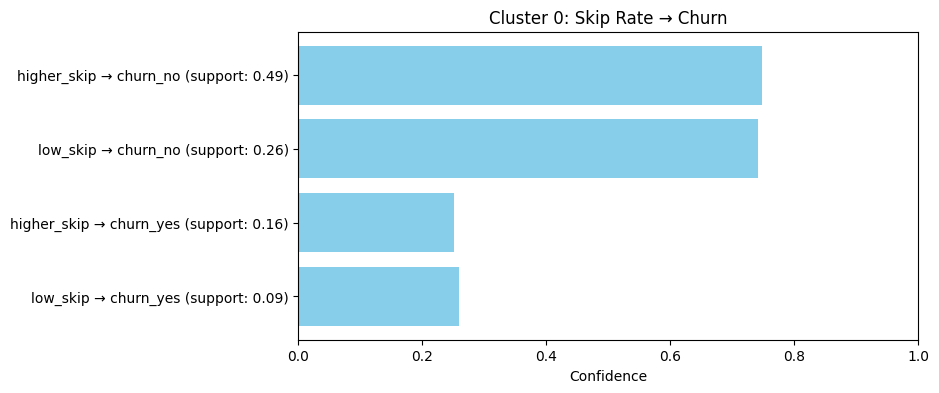

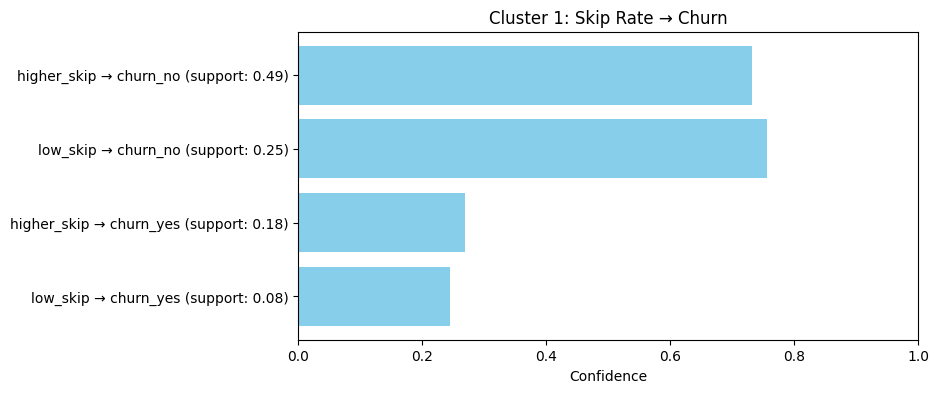

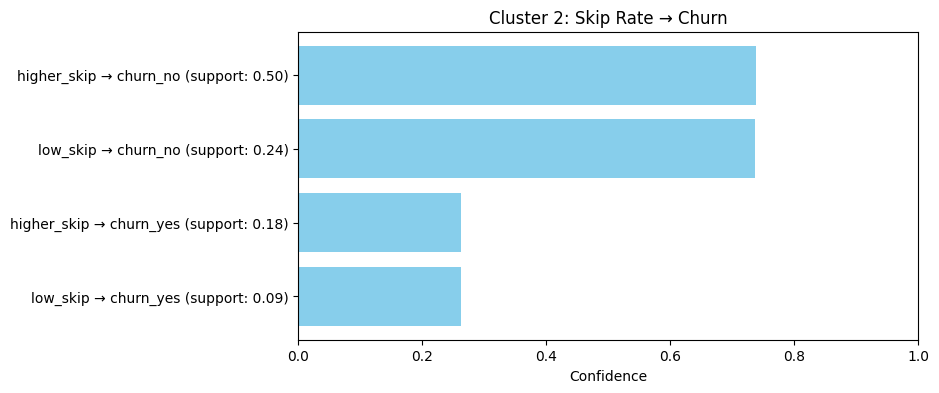

In [ ]:
for c in sorted(cluster_rule_metrics.keys()):
    df_rules = pd.DataFrame(cluster_rule_metrics[c]) 

    if not df_rules.empty:
        rule_labels = [
            f"{row['rule']} (support: {row['support']:.2f})"
            for _, row in df_rules.iterrows()
        ]
        confidences = df_rules['confidence'].tolist()

        # Plot horizontal bar chart
        plt.figure(figsize=(8, 4))
        plt.barh(rule_labels, confidences, color='skyblue')
        plt.xlabel("Confidence")
        plt.title(f"Cluster {c}: Skip Rate → Churn")
        plt.xlim(0, 1)
        plt.gca().invert_yaxis()  # highest confidence on top
        plt.show()
    else:
        print(f"Cluster {c} has no skip_rate → churn rules.")

Visualizes the strength of association between skip rate and churn using lift instead of confidence

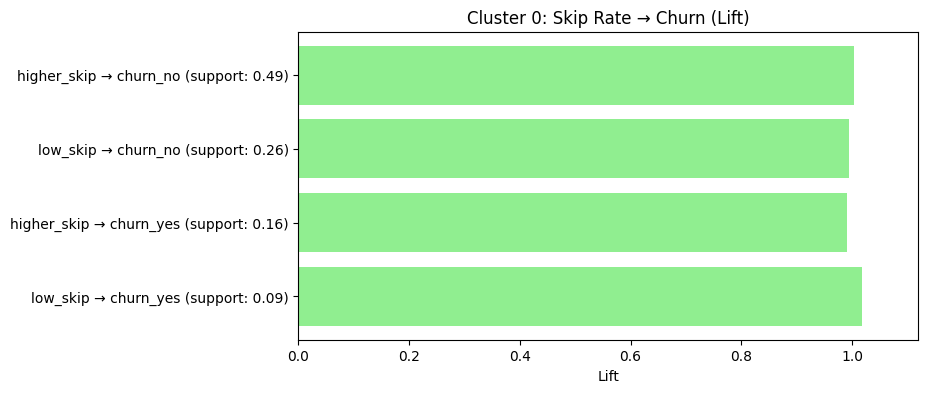

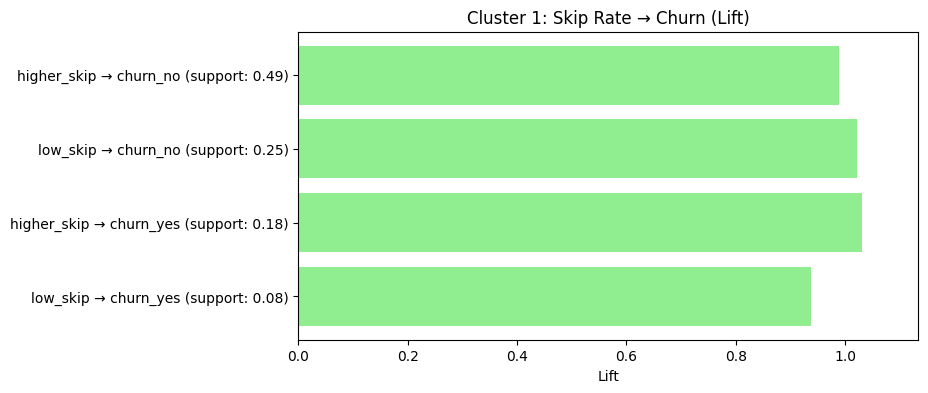

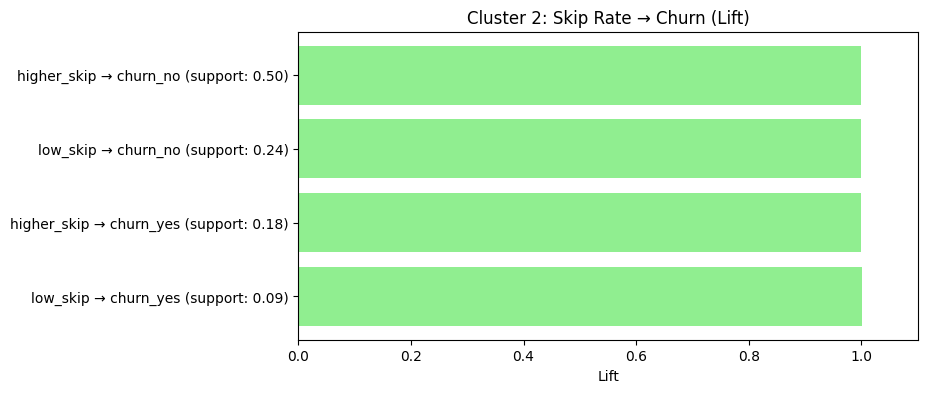

In [ ]:
for c in sorted(cluster_rule_metrics.keys()):
    df_rules = pd.DataFrame(cluster_rule_metrics[c])  

    if not df_rules.empty:
        rule_labels = [
            f"{row['rule']} (support: {row['support']:.2f})"
            for _, row in df_rules.iterrows()
        ]
        lifts = df_rules['lift'].tolist()  # use lift as bar length

        # Plot horizontal bar chart
        plt.figure(figsize=(8, 4))
        plt.barh(rule_labels, lifts, color='lightgreen')
        plt.xlabel("Lift")
        plt.title(f"Cluster {c}: Skip Rate → Churn (Lift)")
        plt.xlim(0, max(lifts) * 1.1)  
        plt.gca().invert_yaxis() 
        plt.show()
    else:
        print(f"Cluster {c} has no skip_rate → churn rules to plot with lift.")